# 95-891 Homework 3 – Computer Vision
Due March 17th, 2022

In this homework, we will implement [AlexNet](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks)-like deep, convolutional neural network (CNN) with PyTorch. We are going to use the CNN to classify flowers into the 102 categories.

The homework consists of the following parts:

- Load and prepare data.
- Load a pretrained Alexnet in PyTorch.
- Set up transfer learning for flower classification problem
- Train the model
- Model performance monitoring and analysis with learning curve
- Questions regarding the design choices

## The places requiring an input are marked with "???".

#### 1.1. Load the dataset which are in three folders, namely train, validation, and test

In [ ]:
!pip3 install torch==1.2.0+cu92 torchvision==0.4.0+cu92 -f https://download.pytorch.org/whl/torch_stable.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 663.1 MB 1.8 kB/s 
     |████████████████████████████████| 8.8 MB 51.8 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.12.1+cu113
    Uninstalling torch-1.12.1+cu113:
      Successfully uninstalled torch-1.12.1+cu113
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.13.1+cu113
    Uninstalling torchvision-0.13.1+cu113:
      Successfully uninstalled torchvision-0.13.1+cu113
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.13.1 requires torch==1.12.1, but you have torch 1.2.0+cu92 which is incompatible.
torchaudio 0.12.1+cu113 requires torch==1.12.1, but you have torch 1.2.0+cu92 which 

In [ ]:
import matplotlib.pyplot as plt
from collections import OrderedDict

from copy import deepcopy
import torch
from torch import nn
from torch import optim
from torchvision import datasets, transforms, models

# download the data and unzip it. You should have three sets of data
#data_dir = 'flowers'
#train_dir = data_dir + '/train'
#valid_dir = data_dir + '/valid'
#test_dir = data_dir + '/test'


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp '/content/drive/MyDrive/ARITIFICIAL_INTELLIGENCE/HW3/flowers.zip' '/content/flowers.zip'

In [ ]:
!unzip '/content/flowers.zip'

Streaming output truncated to the last 5000 lines.
  inflating: flowers/train/53/image_03687.jpg  
  inflating: __MACOSX/flowers/train/53/._image_03687.jpg  
  inflating: flowers/train/53/image_03730.jpg  
  inflating: __MACOSX/flowers/train/53/._image_03730.jpg  
  inflating: flowers/train/53/image_03732.jpg  
  inflating: __MACOSX/flowers/train/53/._image_03732.jpg  
  inflating: flowers/train/53/image_03726.jpg  
  inflating: __MACOSX/flowers/train/53/._image_03726.jpg  
  inflating: flowers/train/53/image_03685.jpg  
  inflating: __MACOSX/flowers/train/53/._image_03685.jpg  
  inflating: flowers/train/53/image_03691.jpg  
  inflating: __MACOSX/flowers/train/53/._image_03691.jpg  
  inflating: flowers/train/53/image_03646.jpg  
  inflating: __MACOSX/flowers/train/53/._image_03646.jpg  
  inflating: flowers/train/53/image_03647.jpg  
  inflating: __MACOSX/flowers/train/53/._image_03647.jpg  
  inflating: flowers/train/53/image_03690.jpg  
  inflating: __MACOSX/flowers/train/53/._imag

#### 1.2. Preview some images
Use PIL library to preview images

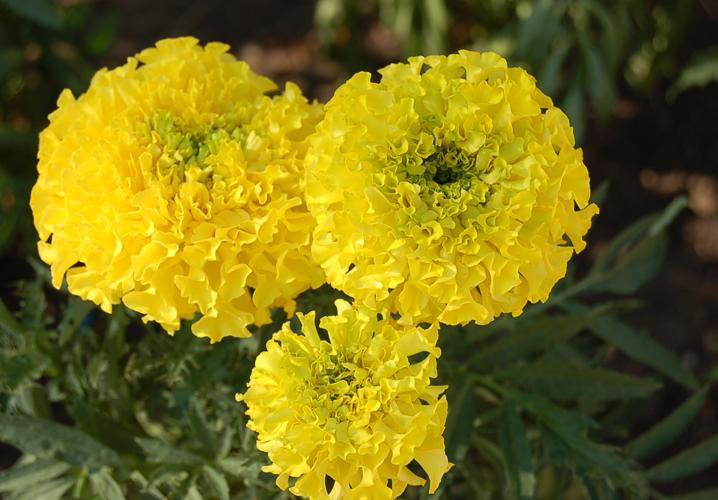

In [ ]:
from PIL import Image  #show one example of image

Image.open("/content/drive/MyDrive/ARITIFICIAL_INTELLIGENCE/HW3/flowers/train/47/image_04953.jpg")

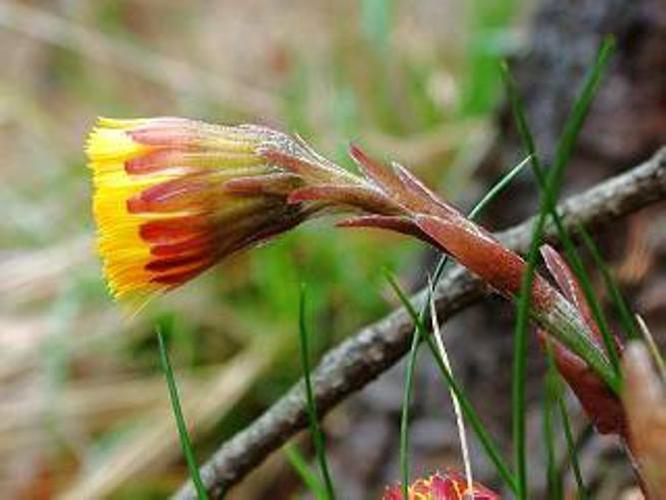

In [ ]:
Image.open("/content/drive/MyDrive/ARITIFICIAL_INTELLIGENCE/HW3/flowers/test/12/image_04012.jpg")

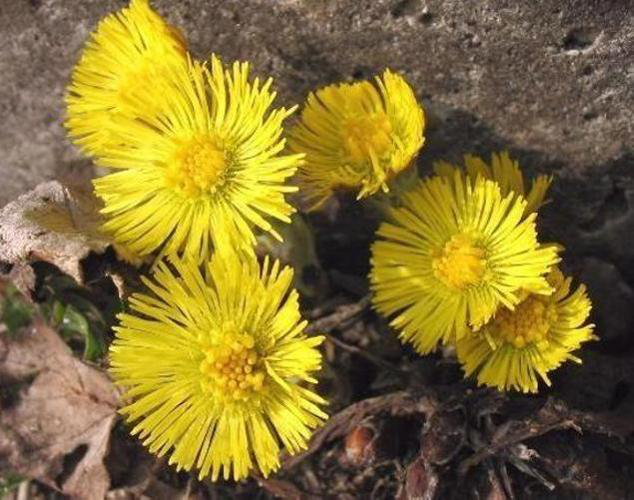

In [ ]:
Image.open("/content/drive/MyDrive/ARITIFICIAL_INTELLIGENCE/HW3/flowers/test/12/image_04077.jpg")

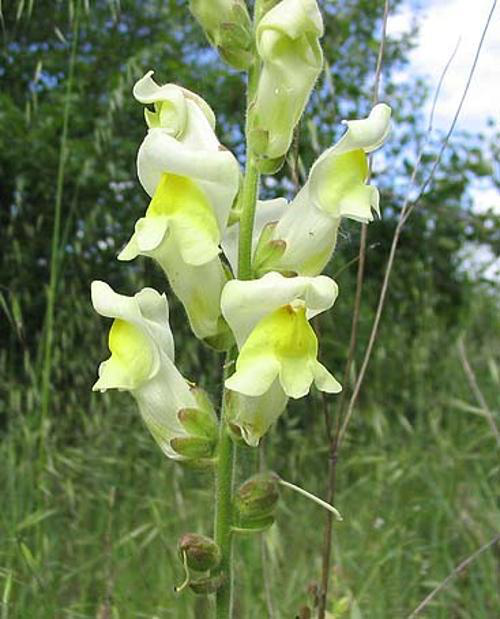

In [ ]:
Image.open("/content/drive/MyDrive/ARITIFICIAL_INTELLIGENCE/HW3/flowers/valid/11/image_03108.jpg")

#### 1.3. Data transformation and processing

In [ ]:
# Process with some data transformation, do not change
data_transforms = {
    'training': transforms.Compose([transforms.RandomResizedCrop(224),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.RandomRotation(30),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406],
                                                         [0.229, 0.224,
                                                          0.225])]),

    'validation': transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(
                                          [0.485, 0.456, 0.406],
                                          [0.229, 0.224, 0.225])]),

    'testing': transforms.Compose([transforms.Resize(256),
                                   transforms.CenterCrop(224),
                                   transforms.ToTensor(),
                                   transforms.Normalize([0.485, 0.456, 0.406],
                                                        [0.229, 0.224,
                                                         0.225])])
}
# This decides how many images to process per training/validation
batch_size = 256

image_datasets = {
    'training': datasets.ImageFolder("/content/flowers/train",
                                     transform=data_transforms['training']),
    'testing': datasets.ImageFolder("/content/flowers/test",
                                    transform=data_transforms['testing']),
    'validation': datasets.ImageFolder("/content/flowers/valid",
                                       transform=data_transforms['validation'])
}

dataloaders = {
    'training': torch.utils.data.DataLoader(image_datasets['training'],
                                            batch_size=batch_size,
                                            shuffle=True),
    'testing': torch.utils.data.DataLoader(image_datasets['testing'],
                                           batch_size=batch_size,
                                           shuffle=False),
    'validation': torch.utils.data.DataLoader(image_datasets['validation'],
                                              batch_size=batch_size,
                                              shuffle=True)
}



In [ ]:
# get the length of each dataloaders; wit batch size=256, you should have 26 batches of training samples, each with 256 images 
training_len = len(image_datasets['training'])
test_len = len(image_datasets['testing'])
validation_len = len(image_datasets['validation'])

class_to_idx = image_datasets['training'].class_to_idx

print('We have ', training_len, 'batches of training images;', 'each with',
      batch_size, 'images')
print('We have ', validation_len, 'batches of validation images;', 'each with',
      batch_size, 'images')

# Let us preview size of each batch
print('Single batch', next(iter(dataloaders['training']))[0].shape)

We have  6552 batches of training images; each with 256 images
We have  818 batches of validation images; each with 256 images
Single batch torch.Size([256, 3, 224, 224])


### *Question 1: What is the effect of random flip and rotation in image data transformation?*
- How does it impact the training?
- Why do not we apply them randomly at the validation or test time?

Ans- Random flips and random rotations are the ways of model improvment without the need to collect more data. These techniques add additional directions, angles and alignment to the existing data from which the model can learn.


- Random rotation prevents data overfitting as the different angles will not let the model memorize the training dataset. 

- The purpose of data augumentation is to avoid generalization of data to imporve model. Applying augumentation on test and avlidation data will kill the purpose of splitting at first place. If the augumentation is performed even on validation or test set then we will not be able to compare the two models after making iterations on training set. It will be hard to track the imporvement in the model with every augumentation if even train and validate dataset is also getting augumented. 

### *Question 2: Explain the meaning of these numbers for a single batch?*
- 256: Each batch contains 256 samples of flowers 
- 3: Total number of channel. 3 channel signifies colored image  
- 224: Height of each sample is 224
- 224: Width of each sample is 224

#### 1.4. Initialize the pretrained model

We are going to use an Alexnet convolutional neural network as our pretrained model. The architecture of the network is shown below
![picture](https://drive.google.com/uc?export=view&id=1XG8ZPxxcaOTaniTm-s_FdK4iRJbdMkhA)

Image credit: https://neurohive.io/en/popular-networks/alexnet-imagenet-classification-with-deep-convolutional-neural-networks/

In [ ]:
# Transfer learning with alexnet
model = models.alexnet(pretrained=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

### 1.5. Update the classifier of the model to be compatible with our datasets

In [ ]:
# In transfer learning, we freeze the feature parameters from the original model
# The most straightforward way is to freeze their gradient update
# see https://pytorch.org/docs/stable/generated/torch.Tensor.requires_grad.html for how to set it
for param in model.parameters():
    param.requires_grad = False

print(model)

# This is the original classifier with alexnet
print()
print('Original classifier of Alexnet')
print(model.classifier)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
# now we need to replace the classifier by our datasets
# Note, fc2's out_feature should match our number of classes, which is 102

# Tip: check the original AlexNet classifier for some thoughts; they are similar.

# Defining number of hidden units in our fully connected layer
hidden_units = 4096
number_of_flowers = len(class_to_idx)

# Defining the fully connected layer that will be trained on the flower images
classifier = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(in_features=9216, out_features=4096)), # this should be a Linear layer; how to connect with the pretrained model?
    ('relu', nn.ReLU()),
    ('dropout', nn.Dropout(0.5)),
    ('fc2', nn.Linear(in_features=4096, out_features=102)), # what is the output of this layer should be
    ('output', nn.LogSoftmax(dim=1))
]))


### *Question 3: Why are we using the Dropout layer in neural networks as shown above?*
- Explain it is usage briefly.
- How does the dropout layer work during the prediction (evaluation) stage?


Ans- We use dropout layer in neural network to avoid the situation of inter dependencies between nerons. This happens when multiple layers are extracting same or similar feature from the input data. This creates dependencies between those layers and also leads to overfitting of the model as only a specific set of features are used to train the model now. This enables the model to learn hidden features. 

- During the prediction stage, the dropout layer is usually not used because by that time model is already trained and dropout layer does not have features at the evaluation stage that can be frozen.

In [ ]:
# double check if the classifier of the model is updated.
model.classifier = classifier
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (fc1): Linear(in_features=9216, out_features=4096, bias=True)
    (relu): ReLU()
    (dropout): Drop

### 1.6. Set up the configurations and train it!
- epochs = 30
- since it is a multiclassification problem, we use [negative log likelihood loss](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html)
- we use the [Adam optimizer](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html)
- learning rate (lr) = 0.001

In each epoch, we go through all the training samples to update the model, and evaluate with the validation samples to see how good the current model is.
- accuracy: mean of the matches in predicted class and the labels
- loss: negative log likelihood loss


**Sample outputs are provided below; but yours may vary**
**Your validation accuracy may be better than train; this is fine**

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

epochs = 30
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)
criterion = nn.NLLLoss() # this is the loss
print_every = 5

validation_accuracies, training_accuracies = [], []
validation_losses, training_losses = [], []

best_validation_accuracy = 0
best_model_weights = None

for e in range(epochs):

    training_loss = training_accuracy = 0
    validation_loss = validation_accuracy = 0

    model.train()

    for batch_idx, (images, labels) in enumerate(dataloaders['training']):

    
        # Moving images & labels to the GPU if there is one
        images, labels = images.to(device), labels.to(device)

        # Pushing batch through network, calculating loss & gradient, and updating weights
       
        log_ps = model.forward(images)
       
        loss = criterion(log_ps, labels)
       
        loss.backward()
        
        optimizer.step()
        

        # Calculating metrics
        ps = torch.exp(log_ps)
        top_ps, top_class = ps.topk(1, dim=1)
        matches = (top_class == labels.view(*top_class.shape)).type(
            torch.FloatTensor)
        train_batch_accuracy = matches.mean()

        

        # Resetting optimizer gradient & tracking metrics
        optimizer.zero_grad()
        training_loss += loss.item()
        train_batch_loss = loss.item()
        training_accuracy += train_batch_accuracy.item()

       

        if batch_idx % print_every == 0:
            # First analyze the training statistics
            print('epoch', e, 'batch', batch_idx)
            print('training loss per batch', train_batch_loss)
            print('training accuracy per batch', train_batch_accuracy.item())
        
        

    # Then do the analysis for the validation only at the end of each training epochs
    
    model.eval()
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(
                dataloaders['validation']):
            images, labels = images.to(device), labels.to(device)
            log_ps = model(images)
            loss = criterion(log_ps, labels) #???
            ps = torch.exp(log_ps) #???
            top_ps, top_class = ps.topk(1, dim=1) #???
            matches = (top_class == labels.view(*top_class.shape)).type(
                torch.FloatTensor)
            validation_batch_accuracy = matches.mean()# ???

            # Tracking validation metrics
            validation_loss += loss.item() #???
            validation_batch_loss = loss.item() #???
            validation_accuracy += validation_batch_accuracy.item() #???

    
    # Save the best model weights so far

    # Tip: see this https://pytorch.org/tutorials/beginner/saving_loading_models.html
    if validation_accuracy >= best_validation_accuracy:
        best_validation_accuracy = validation_accuracy
        best_model_weights = deepcopy(model.state_dict())
        torch.save(best_model_weights, "/content/drive/MyDrive/ARITIFICIAL_INTELLIGENCE/HW3.pt")

    # Summary statistic per epoch
    print('epoch', e, 'summary')
    print('avg training loss per epoch', training_loss / training_len)
    print('avg training accuracy per epoch', training_accuracy / training_len)
    training_losses.append(training_loss / training_len)
    training_accuracies.append(training_accuracy / training_len)

    print('avg validation loss per epoch', validation_loss / validation_len)
    print('avg validation accuracy per epoch',
          validation_accuracy / validation_len)
    validation_losses.append(validation_loss / validation_len)
    validation_accuracies.append(validation_accuracy / validation_len)

    print()

cpu
epoch 0 batch 0
training loss per batch 4.897900581359863
training accuracy per batch 0.01953125
epoch 0 batch 5
training loss per batch 13.793121337890625
training accuracy per batch 0.06640625
epoch 0 batch 10
training loss per batch 6.040386199951172
training accuracy per batch 0.16796875
epoch 0 batch 15
training loss per batch 3.397326707839966
training accuracy per batch 0.234375
epoch 0 batch 20
training loss per batch 3.1228387355804443
training accuracy per batch 0.28515625
epoch 0 batch 25
training loss per batch 2.8672478199005127
training accuracy per batch 0.2697368562221527
epoch 0 summary
avg training loss per epoch 0.026354885472482815
avg training accuracy per epoch 0.0006677664234160795
avg validation loss per epoch 0.008933561063920374
avg validation accuracy per epoch 0.002805432436810146

epoch 1 batch 0
training loss per batch 2.520549774169922
training accuracy per batch 0.390625
epoch 1 batch 5
training loss per batch 2.1736044883728027
training accuracy per

### *Question 4: Report the best model's validation accuracy*
best_validation_accuracy = 0.0044643948888428925 for epoch 29

(Please note that the skeleton code provided had the formula of average validation accuracy where validation accuracy was divided by validation length. But we have already divided thew accuracy by its mean in the middle of the model code. I am not sure if this double dividion is correct as the accuracy that my model gave is very less as is shown by the output. If I were to divide it only once, accuracy would have been better. )

### 1.7. Draw learning curves

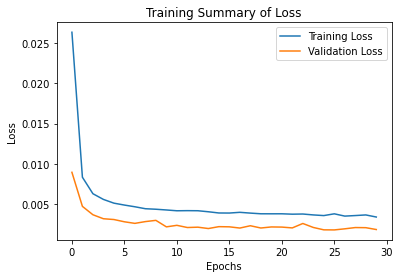

In [ ]:
plt.figure()
plt.title("Training Summary of Loss")
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

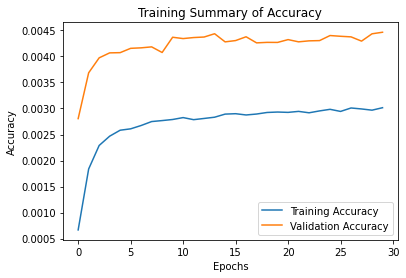

In [ ]:
plt.figure()
plt.title("Training Summary of Accuracy")
plt.plot(training_accuracies, label='Training Accuracy')
plt.plot(validation_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### *Question 5: Briefly describe the plots*

(1) Loss vs Epoch Graph: The loss per batch is reducing within the same epoch. Validation model has a high learning rate as compared to training model. The training loss is continuing to decrease that means that the model is overfitted and might need more data to be trained.

(2) Accuracy vs Epoch Graph: Since the gap between the training line and validation line is big, this indicates huge overfitting in the model.  

### 1.8. Predict on the test data with the best model so far

In [ ]:
# Predict on the test data

# Load the best model so far

model.load_state_dict(best_model_weights)
test_accuracy = 0
test_loss = 0

predictions = []
label_data = []

for images, labels in dataloaders['testing']:
  images, labels = images.to(device), labels.to(device)
  log_ps = model(images)
  ps = torch.exp(log_ps)
  top_ps, top_class = ps.topk(1, dim=1) 

  # print(top_ps[:5], top_class[:5])


  loss = criterion(log_ps, labels) 
   
  
  matches = (top_class == labels.view(*top_class.shape)).type(torch.FloatTensor)

  # print(matches)

  test_batch_accuracy = matches.mean()

  # Tracking test metrics
  test_loss += loss.item() 
  test_batch_loss = loss.item() 
  test_accuracy += test_batch_accuracy.item() 
  predictions.append(top_class) 
  label_data.append(labels) 
  
    # Try to do similar things as validation to get the test accuracy
    # You also need to store the predictions and labels for all the test data, which will be used later
    # you could save them in predictions and label_data
print('Test Accuracy:', test_accuracy/ 4)

Test Accuracy: 0.8543198555707932


### *Question 6: Report the test accuracy with the best model*

The test accuracy of the best model is 85.43%

### *Question 7: Provide a confusion matrix between the ground truth and predicted labels in the test dataset. The rows should correspond to the ground ruth categories and the columns to predicted categories. The confusion matrix here should have raw datapoint counts and should not be normalized as percentages*

### *Question 8: Now normalize the raw confusion matrix reported in the previous question by dividing each row by the sum of all its elements. Include this normalized confusion matrix in your report. It may look small but that is fine.*

### *Question 9: What does the diagnal denote in the normalized confusion matrix? What is the meaning of the number in the row 1 column 2?*

Ans- The diagonal elements denote correctly classified outcomes. The misclassified outcomes are represented on the off diagonals of the confusion matrix. The density of the diagonal is strong showing that most entries are classified correctly. 
The number in row 1 column 2 is- 0% of the all 1s are classified as 2. 

In [ ]:
# prediction_npy[256*3:] = np.array(predictions[3].detach().numpy())
import numpy as np
predictions_npy = np.zeros((819,1))

predictions_npy[256*0:256*1] = np.array(predictions[0].detach().numpy())
predictions_npy[256*1:256*2] = np.array(predictions[1].detach().numpy())
predictions_npy[256*2:256*3] = np.array(predictions[2].detach().numpy())
predictions_npy[256*3:] = np.array(predictions[3].detach().numpy())

In [ ]:
label_data_npy = np.zeros((819))

label_data_npy[256*0:256*1] = np.array(label_data[0].detach().numpy())
label_data_npy[256*1:256*2] = np.array(label_data[1].detach().numpy())
label_data_npy[256*2:256*3] = np.array(label_data[2].detach().numpy())
label_data_npy[256*3:] = np.array(label_data[3].detach().numpy())

# label_data_npy

confusion matrix
[[4 0 0 ... 0 0 0]
 [0 3 0 ... 0 0 0]
 [0 0 8 ... 0 0 0]
 ...
 [0 0 0 ... 3 0 0]
 [0 0 0 ... 0 3 0]
 [0 0 0 ... 0 0 7]]



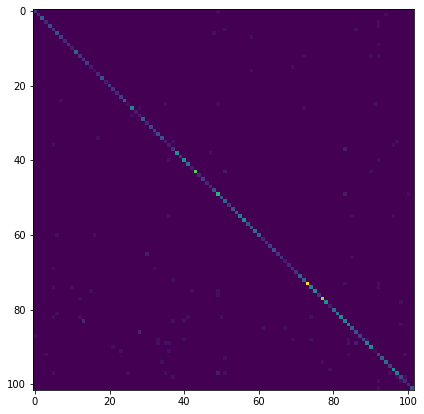

In [ ]:
# Please plot the confusion matrix other than print() if possible
from sklearn.metrics import confusion_matrix as conf_mat


cf =conf_mat(predictions_npy, label_data_npy)

print('confusion matrix')
print(cf)
print()
plt.figure(figsize = (12,7))
plt.imshow(cf)
plt.show()



In [ ]:

import pandas as pd
cf_pd = pd.DataFrame(cf)

normalized confusion matrix
      0      1      2     3      4          5    6    7    8    9    ...  \
0    80.0    0.0    0.0   0.0    0.0   0.000000  0.0  0.0  0.0  0.0  ...   
1     0.0  100.0    0.0   0.0    0.0   0.000000  0.0  0.0  0.0  0.0  ...   
2     0.0    0.0  100.0   0.0    0.0   0.000000  0.0  0.0  0.0  0.0  ...   
3     0.0    0.0    0.0  75.0    0.0   0.000000  0.0  0.0  0.0  0.0  ...   
4     0.0    0.0    0.0   0.0  100.0   0.000000  0.0  0.0  0.0  0.0  ...   
..    ...    ...    ...   ...    ...        ...  ...  ...  ...  ...  ...   
97    0.0    0.0    0.0   0.0    0.0  11.111111  0.0  0.0  0.0  0.0  ...   
98    0.0    0.0    0.0   0.0    0.0   0.000000  0.0  0.0  0.0  0.0  ...   
99    0.0    0.0    0.0   0.0    0.0   0.000000  0.0  0.0  0.0  0.0  ...   
100   0.0    0.0    0.0   0.0    0.0   0.000000  0.0  0.0  0.0  0.0  ...   
101   0.0    0.0    0.0   0.0    0.0   0.000000  0.0  0.0  0.0  0.0  ...   

          92   93        94         95   96         97     

<function matplotlib.pyplot.show(*args, **kw)>

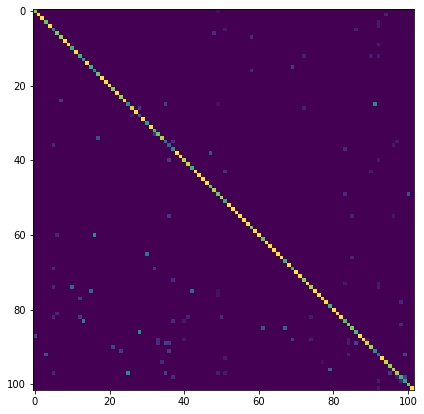

In [ ]:
# normalized confusion matrix
print('normalized confusion matrix')
ncf = pd.DataFrame(cf_pd/np.sum(cf_pd) *100)
print(ncf)
plt.figure(figsize = (12,7))
plt.imshow(ncf)

plt.show


### *Question 10: Transfer Learning*
- What is the purpose of a pretrained model and why should it work?

Ans: Pre trained models are usually modelled on huge amount of resources that are not readily available to everyone easily and are also better trained model given large datasets they are trained on. 

Any model that gets trained will be able to recignize the initial layers of the models easily. The problem arises in the later layers that will take a lot of data to train. To avoid duplication of efforts and establishing a neural network from scratch, we use pre trained models where we use the initial layers from the pre trained model itself and replace the later layers in that model with our data for training. It works because it has been trained on the big dataset and varied combinations of later layers with our new dataset will give better results. 


- Why should we freeze the features' gradient in the pretrained model but only update the classifier?

Ans: Freezing the features gradients in pre trained model lets avoid destroying any of the information they contain during future training rounds. Freezing will also prevent the weights in a given layer from being updated during training. To tune the model for our particular subject matter, we unfreeze the last few layers and model those so as to learn to turn the old features into predictions on a new dataset. 

Updating only the classifier gives an easy way to change the number of hidden layers and to quickly adjust the dropout rate. This combination trains model better on different combinations of hidden layers. 


- What may happen if we do not freeze the features' gradient?

Ans: Not freezing the features' gradient will mean that we will have to do keep updating the weights to all the layers of the network in every backpropagation which will this means a huge increase in computation time as the model is first trying to learn extracting generic features from scratch. However, not freezing will at the same time increase accuracy as the model will be able to train on entire feature set.